<a href="https://colab.research.google.com/github/erfan-sams/sexsim-detection/blob/main/LLMs_sexism_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
The token `LLMs` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushi

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

In [ ]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import pipeline, BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib as plt

from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

### Phi3-mini

In [ ]:
model_id = "microsoft/Phi-3-mini-4k-instruct"

# Configure quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

tokenizer_phi = AutoTokenizer.from_pretrained(model_id)
tokenizer_phi.pad_token = tokenizer_phi.eos_token
model_phi = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="cuda")



tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

### Mistral v3

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.3"

# Configure quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

tokenizer_mistral = AutoTokenizer.from_pretrained(model_id)
tokenizer_mistral.pad_token = tokenizer_mistral.eos_token
model_mistral = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="cuda")



tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [ ]:
# prompt = [
#     {
#         'role': 'system',
#         'content': 'You are an annotator for sexism detection.'
#     },
#     {
#         'role': 'user',
#         'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

#         TEXT:
#         {text}

#         ANSWER:
#         """
#     }
# ]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [ ]:
def prepare_prompts(texts):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    prompt_list = []
    for text in texts:
        # Prepare the flat string prompt
        prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': f"""Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]
        prompt_list.append(prompt)

    return prompt_list

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model, tokenizer, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """

  text_generator = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
  )

  generation_args = {
      "max_new_tokens": 100,
      "return_full_text": False,
      "temperature": 0.0,
      "do_sample": False,
  }

  responses = []
  for i in tqdm(range(len(prompt_examples))):
    response = text_generator(prompt_examples[i], **generation_args)
    response = response[0]['generated_text']
    responses.append(response.strip())  # Strip extra whitespaces
  return responses

In [ ]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  if response == "YES":
    return 1
  elif response == "NO":
    return 0
  return None

## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [ ]:
def compute_metrics(y_pred, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  # y_pred = []
  # for response in responses:
  #   y_pred.append(process_response(response))

  accuracy = (y_pred.values == y_true.values & y_pred.notna()).mean()
  fail_ratio = sum(y_pred.isna())/len(y_pred)

  return {
      'accuracy': accuracy,
      'fail-ratio': fail_ratio,
  }

In [ ]:
df = pd.read_csv('./a2_test.csv')
df['y_true'] = df.label_sexist.apply(lambda x: 1 if x == 'sexist' else 0)

In [ ]:
texts = df.text.to_list()
prompts = prepare_prompts(texts)
responses_phi = generate_responses(model_phi, tokenizer_phi, prompts)

df['y_pred_phi'] = responses_phi
df['y_pred_phi'] = df['y_pred_phi'].apply(process_response)
compute_metrics(df.y_pred_phi, df.y_true)
df['y_pred_phi'] = df['y_pred_phi'].fillna(0)

Device set to use cuda
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [03:11<00:00,  1.57it/s]


In [ ]:
texts = df.text.to_list()
prompts = prepare_prompts(texts)
responses_mistral = generate_responses(model_mistral, tokenizer_mistral, prompts)

df['y_pred_mistral'] = responses_mistral
df['y_pred_mistral'] = df['y_pred_mistral'].apply(process_response)
compute_metrics(df.y_pred_mistral, df.y_true)
df['y_pred_mistral'] = df['y_pred_mistral'].fillna(0)

Device set to use cuda
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [06:23<00:00,  1.28s/it]


In [ ]:
print(classification_report(df.y_true, df.y_pred_phi))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       150
           1       0.63      0.68      0.65       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300



In [ ]:
print(classification_report(df.y_true, df.y_pred_mistral))

              precision    recall  f1-score   support

           0       0.86      0.21      0.34       150
           1       0.55      0.97      0.70       150

    accuracy                           0.59       300
   macro avg       0.71      0.59      0.52       300
weighted avg       0.71      0.59      0.52       300



# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [ ]:
df_demons = pd.read_csv('./demonstrations.csv')

In [ ]:
df_demons['y_true'] = df_demons.label_sexist.apply(lambda x: 'YES' if x == 'sexist' else 'NO')

In [ ]:
df_demons

,rewire_id,text,label_sexist,y_true
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist,NO
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist,YES
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist,NO
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist,YES
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist,YES
...,...,...,...,...
995,sexism2022_english-18597,This bitch is so ugly she'd have to put a knif...,sexist,YES
996,sexism2022_english-3509,Even the worst incel can pick up a 40+ multi k...,sexist,YES
997,sexism2022_english-7186,Reddit front page is almost always pure mangin...,not sexist,NO
998,sexism2022_english-6196,Lack of self-awareness Not aware of strong emo...,not sexist,NO


In [ ]:
def prepare_prompts_demonstrations(texts, examples):

    examples_section = ""
    for example_text, example_answer in examples:
        examples_section += f"TEXT: {example_text}\nANSWER: {example_answer}\n"

    prompt_list = []
    for text in texts:
        # Prepare the flat string prompt
        prompt = [
            {
                'role': 'system',
                'content': 'You are an annotator for sexism detection.'
            },
            {
                'role': 'user',
                'content': f"""Your task is to classify input text as containing sexism or not. Respond only YES or NO.

                EXAMPLES:
                {examples_section}

                TEXT:
                {text}

                ANSWER:
                """
            }
]
        prompt_list.append(prompt)

    return prompt_list

In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """

  not_sexist_sample = (demonstrations[demonstrations['y_true'] == "NO"].sample(num_per_class))[['text', 'y_true']]
  sexist_sample = (demonstrations[demonstrations['y_true'] == "YES"].sample(num_per_class))[['text', 'y_true']]
  samples = pd.concat([not_sexist_sample, sexist_sample])
  examples = list(zip(samples['text'], samples['y_true']))

  return examples

In [ ]:
texts = df.text.to_list()
examples = build_few_shot_demonstrations(df_demons, num_per_class=2)
prompts = prepare_prompts_demonstrations(texts, examples)
responses_phi = generate_responses(model_phi, tokenizer_phi, prompts)

df['y_pred_demons_phi'] = responses_phi
df['y_pred_demons_phi'] = df['y_pred_demons_phi'].apply(process_response)
print(compute_metrics(df.y_pred_demons_phi, df.y_true))
df['y_pred_demons_phi'] = df['y_pred_demons_phi'].fillna(0)

Device set to use cuda
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [06:16<00:00,  1.25s/it]

{'accuracy': 0.6333333333333333, 'fail-ratio': 0.006666666666666667}


In [ ]:
texts = df.text.to_list()
examples = build_few_shot_demonstrations(df_demons, num_per_class=2)
prompts = prepare_prompts_demonstrations(texts, examples)
responses_mistral = generate_responses(model_mistral, tokenizer_mistral, prompts)

df['y_pred_demons_mistral'] = responses_mistral
df['y_pred_demons_mistral'] = df['y_pred_demons_mistral'].apply(process_response)
print(compute_metrics(df.y_pred_demons_mistral, df.y_true))
df['y_pred_demons_mistral'] = df['y_pred_demons_mistral'].fillna(0)

Device set to use cuda
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 300/300 [12:10<00:00,  2.43s/it]

{'accuracy': 0.71, 'fail-ratio': 0.05}


## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

#### Phi

In [ ]:
print(classification_report(df.y_true, df.y_pred_demons_phi))

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       150
           1       0.72      0.45      0.56       150

    accuracy                           0.64       300
   macro avg       0.66      0.64      0.63       300
weighted avg       0.66      0.64      0.63       300



Text(50.722222222222214, 0.5, 'True labels')

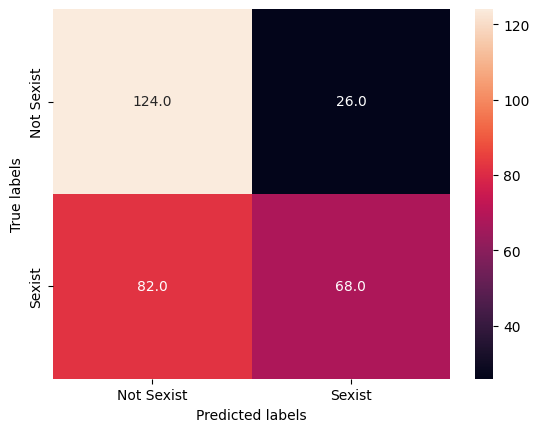

In [ ]:
df_cm = confusion_matrix(df.y_true, df.y_pred_demons_phi, labels=[0, 1])
df_cm = pd.DataFrame(df_cm, index=["Not Sexist", "Sexist"], columns=["Not Sexist", "Sexist"])
ax = sn.heatmap(df_cm, annot=True, fmt=".1f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

In [ ]:
mismatch_df_phi = df[df['y_pred_demons_phi'] != df['y_true']][['text', 'y_true']]

In [ ]:
mismatch_df_phi[mismatch_df_phi['y_true'] == 1].text.values

array(['Don\'t think that using the word "feminine" wasn\'t strategic, Mo. It was. And I couldn\'t agree more with everything else you wrote. They attempt to bring the rest of us down to their level. Not gonna happen ... Lol, men are a gift from God.',
       "That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support.",
       "Thanks for the response brotha, I'll work towards it. It's just another nasty remnant of my beta days. But like you said, I'm a man. Men conquer.",
       'Giving women all your money is good personality.',
       "How long will it take a woman to mentally move on from the situation? Cause they're fond of bringing up shit from before my ancestors",
       "You say you're a MGTOW, why in the hell did you agree to this? She made her damn bed. Bet your ass she would have never done the same for you if you were in her situation.",
       '*women spend all free time trying to block male on

In [ ]:
mismatch_df_phi[mismatch_df_phi['y_true'] == 0].text.values

array(['Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior.',
       '#Italy: #Muslim #migrant gropes American student’s girlfriend, then #stabs the student twice: [URL]',
       "Yes, let's all be LECTURED by a Jack-ass like this Jimbo Bono's Bud in Red #BoycottedOscars #BoycottHollywood",
       'They are just so pissed off cuz no woman wants neither one of them and they know it. Both little fat round pigs who probably play tiddlywinks together!',
       'Freedom? Yep, every year when I pay my taxes so a bunch of third world scum can steal the money and rape our women, I thank those vets for giving me that freedom!',
       'Intolerant feminist attacks “Doctor Who” British TV show for not being transgender or black enough - Tyranny News [URL]',
       "The mormans have female cucks. We literally outlawed it because it's bad for scociety.",
       "I don't know i

#### Mistral

In [ ]:
print(classification_report(df.y_true, df.y_pred_demons_mistral))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       150
           1       0.71      0.83      0.77       150

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.75       300



Text(50.722222222222214, 0.5, 'True labels')

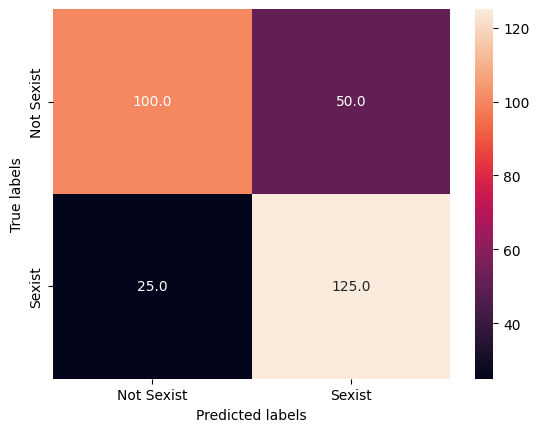

In [ ]:
df_cm = confusion_matrix(df.y_true, df.y_pred_demons_mistral, labels=[0, 1])
df_cm = pd.DataFrame(df_cm, index=["Not Sexist", "Sexist"], columns=["Not Sexist", "Sexist"])
ax = sn.heatmap(df_cm, annot=True, fmt=".1f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

In [ ]:
mismatch_df_mistral = df[df['y_pred_demons_mistral'] != df['y_true']][['text', 'y_true']]

In [ ]:
mismatch_df_mistral[mismatch_df_mistral['y_true'] == 1].text.values

array(["That's female fantasy. I have a lot of experience in that field and nurses marry doctors all the time. Something statistics also support.",
       "Thanks for the response brotha, I'll work towards it. It's just another nasty remnant of my beta days. But like you said, I'm a man. Men conquer.",
       'Giving women all your money is good personality.',
       "How long will it take a woman to mentally move on from the situation? Cause they're fond of bringing up shit from before my ancestors",
       'If you’re 6’3” chad with a 2” dick she will find another chad. Maybe not an incel but fuck I can sympathize.',
       'Greens, eh? The fateful question of the Occident is thus now whether young female university graduates can be continually served with yoga and Pilates courses even amidst the ruins looming on the horizon.',
       "No she's not lmao. IRL ratings are sugarcoated. She might be a 5 or a 6 IRL, but her more accurate PSL (puahate-sluthate-lookism) rating is 4. [URL] La

In [ ]:
mismatch_df_mistral[mismatch_df_mistral['y_true'] == 0].text.values

array(['Excellent, I was just looking at another post where the female fvcked men to get grades, why support that, or even risk exposing ourselves to that type of fraudulent behavior.',
       '\u202aImport the third world and become the third world. You won’t see feminists protesting about this. \u202c \u202a[URL]',
       'The black African will soon be labeling her a racist. Race card coming soon',
       'Good - the grid girls can finally get back into F1',
       'They are just so pissed off cuz no woman wants neither one of them and they know it. Both little fat round pigs who probably play tiddlywinks together!',
       'First. Black Democrats upset that Black unemployment is down. Now. Feminists upset with good looking women so they get Grid girls fired. Next. LGBTQ community wants AIDS to come back.',
       'Ah, /r/redpillwomen, where ladies are free to speak their minds about any subject they like, so long as it involves either trading recipes or bashing Gloria Steinem. And 

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End